In [1]:
import os
import sys
import json
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp

from tensorflow import keras
from itertools import combinations
from scipy.stats import shapiro, f_oneway, kruskal
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.multicomp import MultiComparison

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(os.path.join(module_path))

from functions.plotting import plot_bars, plot_bar_from_dict

WIDTH = 150
HEIGHT = 150

In [2]:
data_dir = os.path.join(
    '..',
    '..',
    '..',
    'data1',
    'images_original_inception_resnet_v2_150x150_categorized')
test_data_dir = os.path.join(data_dir, 'validation')
test_ds = keras.utils.image_dataset_from_directory(
    directory=test_data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(HEIGHT, WIDTH))

Found 2000 files belonging to 7 classes.


In [3]:
ROOT_NAME = 'xception_dealing_with_imbalance'
models_dir = os.path.join(
    '..',
    '..',
    'models',
    'data1')
model_file_names = list(filter(lambda model_file_name: ROOT_NAME in model_file_name, os.listdir(models_dir)))

In [4]:
def get_accuracies_and_losses(models: list[str]) -> (dict[str, float], dict[str, float]):
    accuracies = {}
    losses = {}

    for model_name in models:
        model_path = os.path.join(models_dir, model_name)
        model = keras.models.load_model(model_path)
        loss, _, _, accuracy, _, _ = model.evaluate(test_ds)
        accuracies[model_name] = accuracy
        losses[model_name] = loss

    return accuracies, losses

In [5]:
accuracies_file = os.path.join('..', '..', 'histories', f'{ROOT_NAME}_accuracies.json')
losses_file = os.path.join('..', '..', 'histories', f'{ROOT_NAME}_losses.json')

In [6]:
if not os.path.exists(accuracies_file):
    accuracies, losses = get_accuracies_and_losses(model_file_names)

    with open(accuracies_file, 'w') as json_file:
        json.dump(accuracies, json_file, indent=4)
    with open(losses_file, 'w') as json_file:
        json.dump(losses, json_file, indent=4)

In [7]:
with open(accuracies_file, 'r') as accuracies_file_handle:
    accuracies = json.load(accuracies_file_handle)
with open(losses_file, 'r') as losses_file_handle:
    losses = json.load(losses_file_handle)

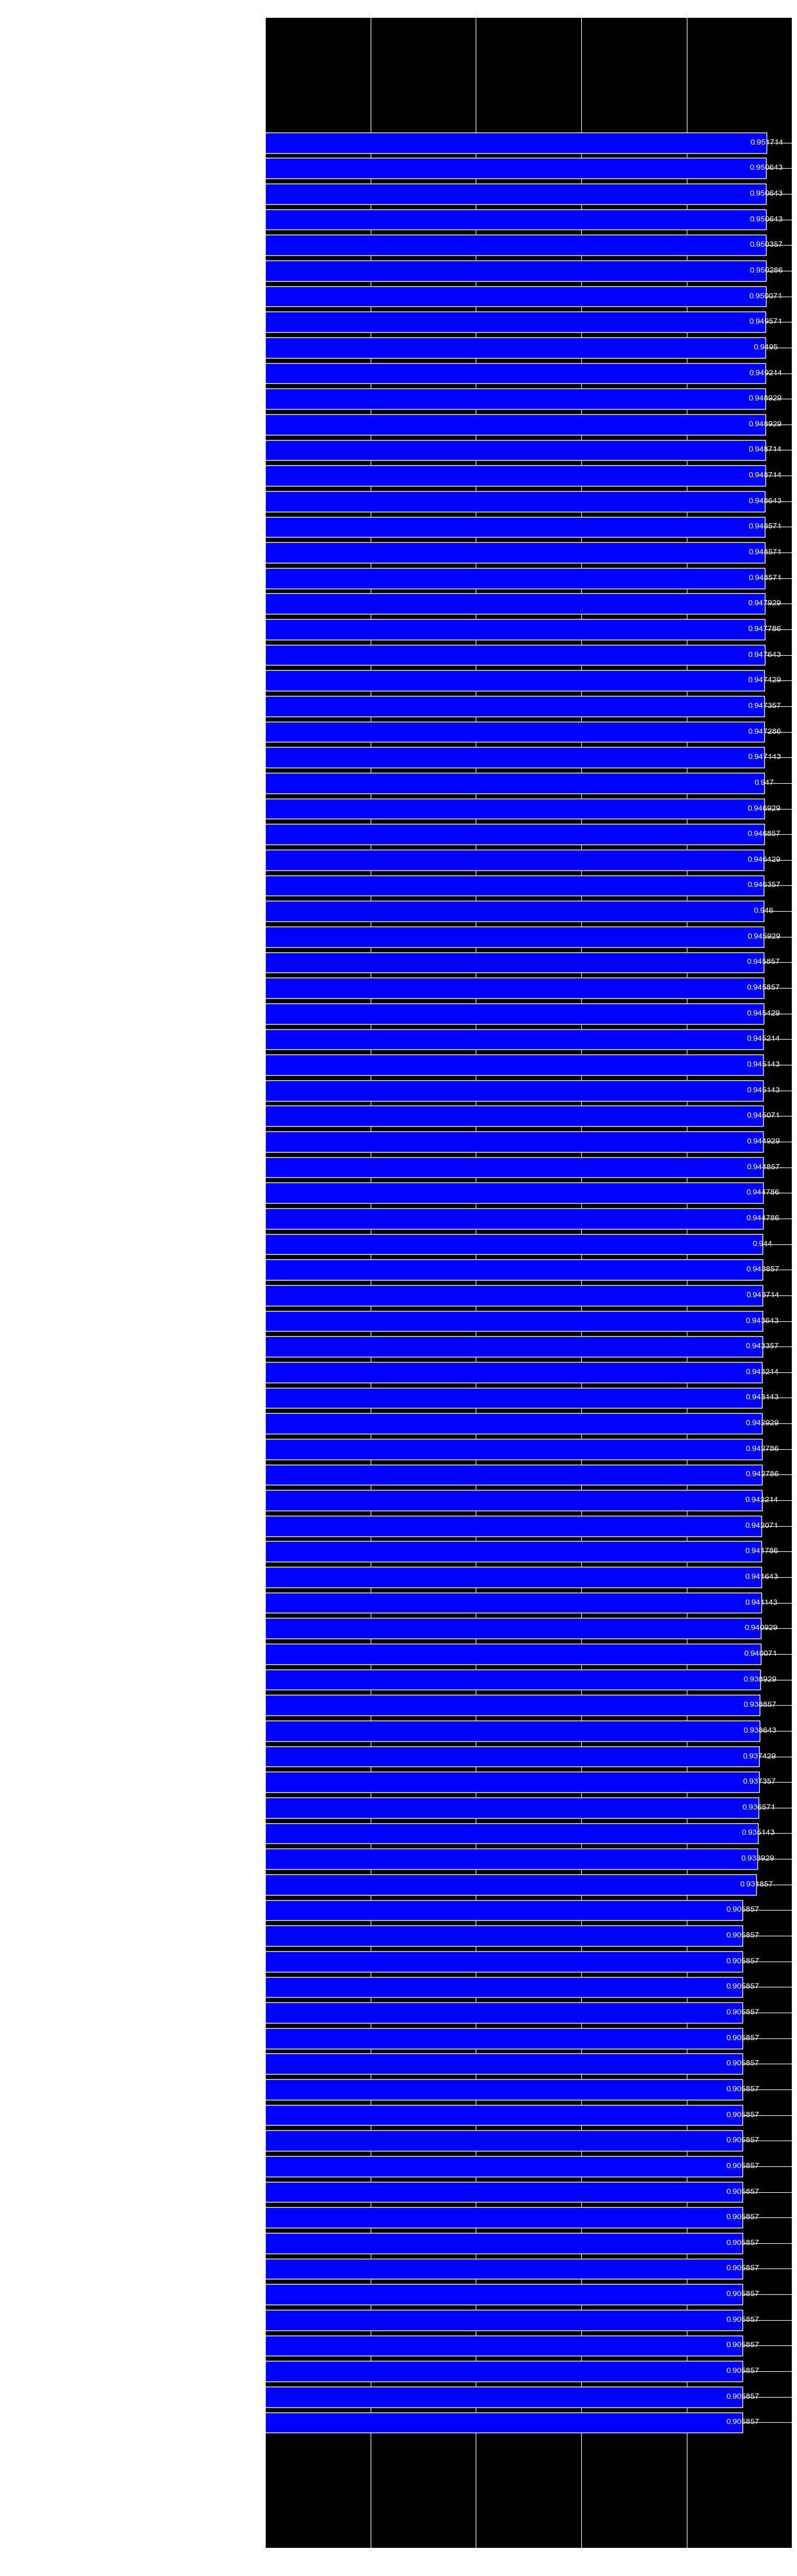

In [8]:
root = os.path.join('..', '..', 'plots', 'testing')
accuracies_pdf_path = os.path.join(root, f'{ROOT_NAME}_accuracies.pdf')

plot_bar_from_dict(accuracies, 'Model Accuracies', 'Name', 'Accuracy', accuracies_pdf_path)

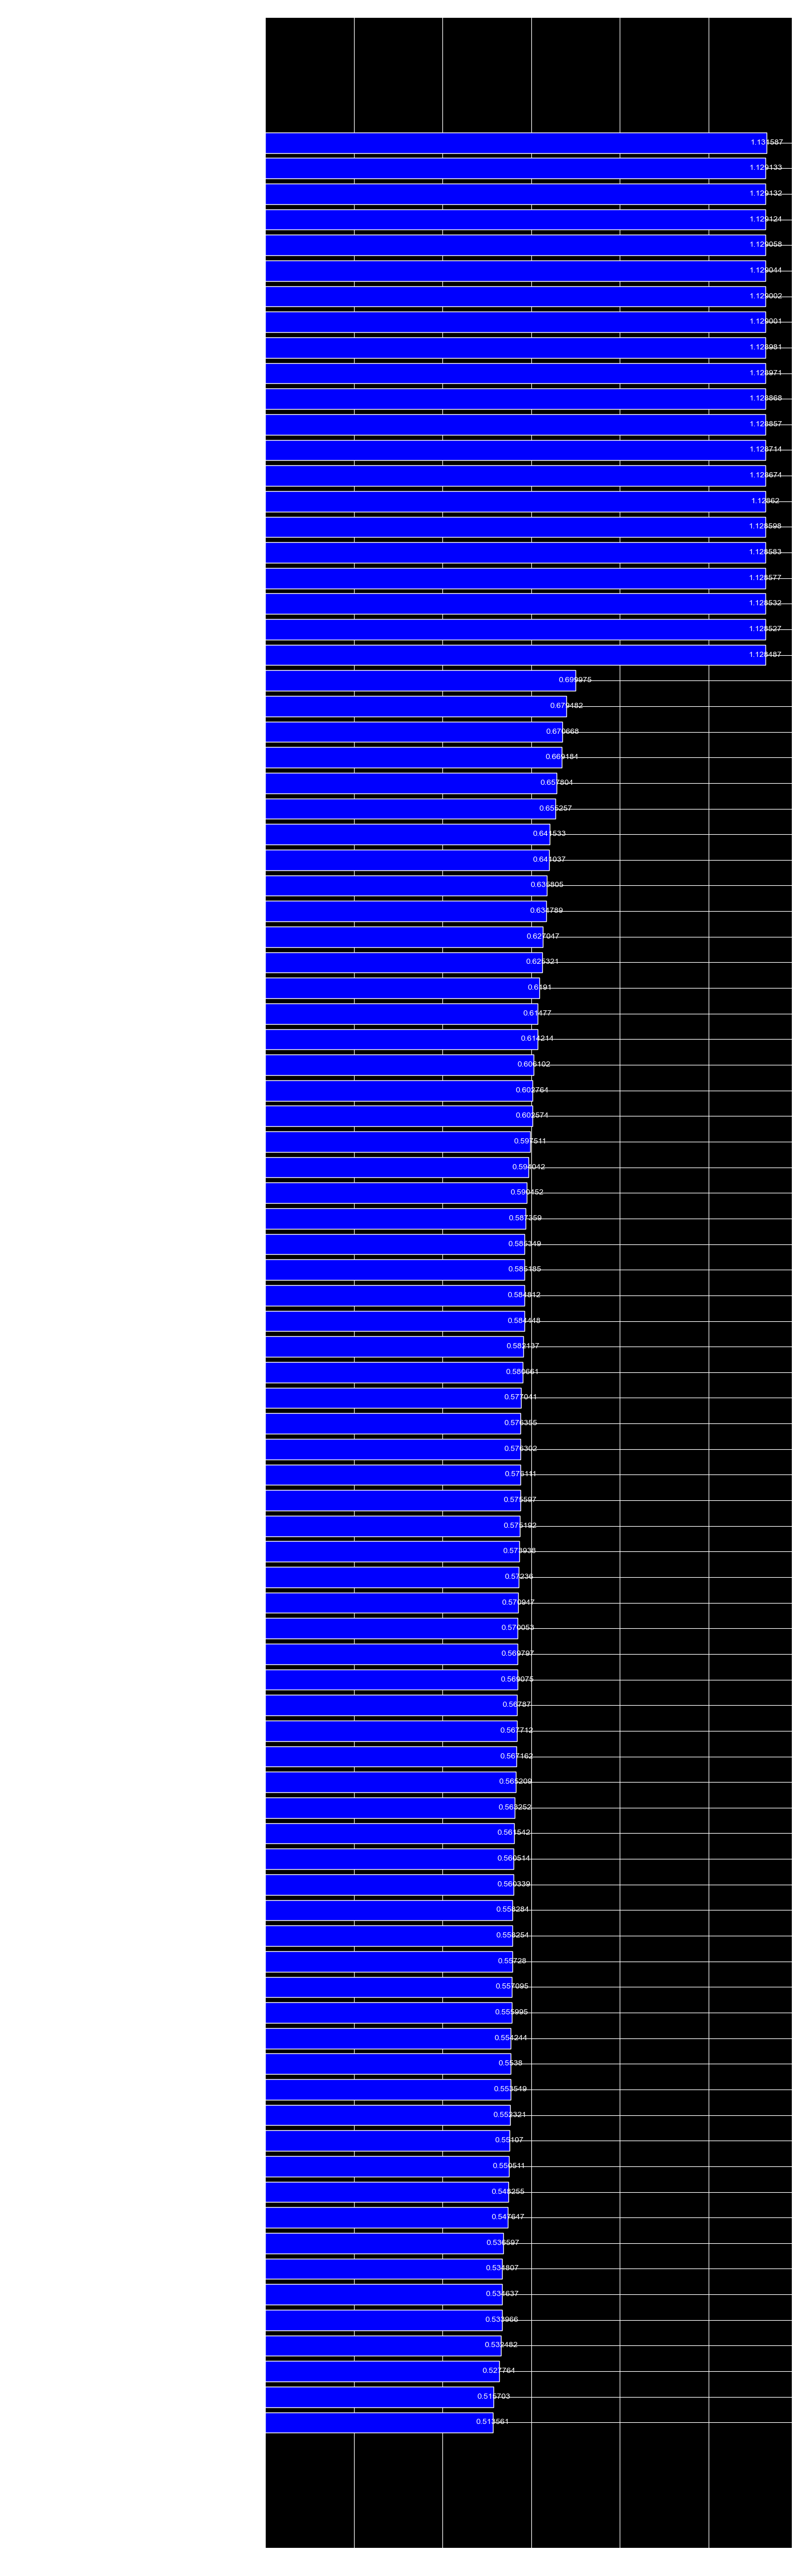

In [9]:
losses_pdf_path = os.path.join(root, f'{ROOT_NAME}_losses.pdf')

plot_bar_from_dict(losses, 'Model Losses', 'Name', 'Accuracy', losses_pdf_path)

In [10]:
model_categories = set(map(lambda name: '_'.join(name.split('_')[:-2]), model_file_names))
grouped_models = {key: list(filter(lambda name: name.startswith(key), model_file_names)) for key in model_categories}
keyed_accuracies = {key: [] for key in grouped_models}
keyed_losses = {key: [] for key in grouped_models}


def categorize_numbers(for_dict: dict[str, list[float]], numbers_dict: dict[str, float]) -> None:
    for group, value in for_dict.items():
        vals = [
            value for key, value in numbers_dict.items()
            if key.startswith(group)]

        value.extend(vals)


categorize_numbers(keyed_accuracies, accuracies)
categorize_numbers(keyed_losses, losses)

In [13]:
ALPHA = .05
anova_testable_groups = []
kruskal_walis_testable_groups = []


def assign_models_to_groups(models: list[float], col: str) -> None:
    _, p_value = shapiro(models)

    if p_value >= ALPHA:
        anova_testable_groups.append(col)
    else:
        kruskal_walis_testable_groups.append(col)


keys = list(keyed_accuracies.keys())

for idx in range(len(keys)):
    assign_models_to_groups(keyed_accuracies[keys[idx]], keys[idx])

In [14]:
kruskal_values = []

for col in kruskal_walis_testable_groups:
    kruskal_values.append(keyed_accuracies[col])

h_stat_kruskal, p_value_kruskal = kruskal(*kruskal_values)

print(f'Kruskal-Wallis p-value: {p_value_kruskal}')

Kruskal-Wallis p-value: 0.005683182963269254


Kruskal-Wallis p-value is relatively small - smaller than the chosen ALPHA value. I reject the null hypothesis of equal means. Given this result, it's warranted to proceed to post-hoc analysis, but since there are only two group, it's known that they are different.

In [20]:
name_initial_bias_only = ''
best_acc_initial_bias_only = 0

for key, value in accuracies.items():
    if 'xception_dealing_with_imbalance_1_initial_bias_only' in key and value > best_acc_initial_bias_only:
        name_initial_bias_only = key
        best_acc_initial_bias_only = value

model_path_initial_bias_only = os.path.join(models_dir, name_initial_bias_only)
model_initial_bias_only = keras.models.load_model(model_path_initial_bias_only)
prediction_initial_bias_only = model_initial_bias_only.predict(test_ds)

63/63 [==============================] - 3s 34ms/step


In [23]:
name_oversampling_and_bias = ''
best_acc_oversampling_and_bias = 0

for key, value in accuracies.items():
    if 'xception_dealing_with_imbalance_2_oversampling_and_bias' in key and value > best_acc_oversampling_and_bias:
        name_oversampling_and_bias = key
        best_acc_oversampling_and_bias = value

model_path_oversampling_and_bias = os.path.join(models_dir, name_oversampling_and_bias)
model_oversampling_and_bias = keras.models.load_model(model_path_oversampling_and_bias)
prediction_oversampling_and_bias = model_oversampling_and_bias.predict(test_ds)

63/63 [==============================] - 3s 34ms/step


In [21]:
name_oversampling_only = ''
best_acc_oversampling_only = 0

for key, value in accuracies.items():
    if 'xception_dealing_with_imbalance_2_oversampling_only' in key and value > best_acc_oversampling_only:
        name_oversampling_only = key
        best_acc_oversampling_only = value

model_path_oversampling_only = os.path.join(models_dir, name_oversampling_only)
model_oversampling_only = keras.models.load_model(model_path_oversampling_only)
prediction_oversampling_only = model_oversampling_only.predict(test_ds)

63/63 [==============================] - 3s 38ms/step


In [57]:
y_pred_initial_bias_only = np.argmax(prediction_initial_bias_only, axis=1)
y_pred_oversampling_only = np.argmax(prediction_oversampling_only, axis=1)
y_pred_oversampling_and_bias = np.argmax(prediction_oversampling_and_bias, axis=1)

In [58]:
y_test = []

for _, labels in test_ds:
    y_test.extend(np.argmax(labels.numpy(), axis=-1))

y_test = np.array(y_test)

In [59]:
accuracy1 = np.sum(y_pred_initial_bias_only == y_test) / len(y_test)
accuracy2 = np.sum(y_pred_oversampling_only == y_test) / len(y_test)
accuracy3 = np.sum(y_pred_oversampling_and_bias == y_test) / len(y_test)

print(f"Accuracy of the first set of predictions: {accuracy1 * 100:.2f}%")
print(f"Accuracy of the second set of predictions: {accuracy2 * 100:.2f}%")
print(f"Accuracy of the third set of predictions: {accuracy3 * 100:.2f}%")

Accuracy of the first set of predictions: 50.05%
Accuracy of the second set of predictions: 52.25%
Accuracy of the third set of predictions: 50.85%


In [40]:
def show_report(y_pred) -> None:
    report = classification_report(y_test, y_pred, target_names=test_ds.class_names, zero_division=0)
    print(report)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

              precision    recall  f1-score   support

       akiec       0.04      0.05      0.04        65
         bcc       0.04      0.04      0.04       102
         bkl       0.06      0.06      0.06       219
          df       0.00      0.00      0.00        23
         mel       0.14      0.10      0.12       222
          nv       0.67      0.69      0.68      1341
        vasc       0.00      0.00      0.00        28

    accuracy                           0.49      2000
   macro avg       0.14      0.13      0.13      2000
weighted avg       0.47      0.49      0.48      2000



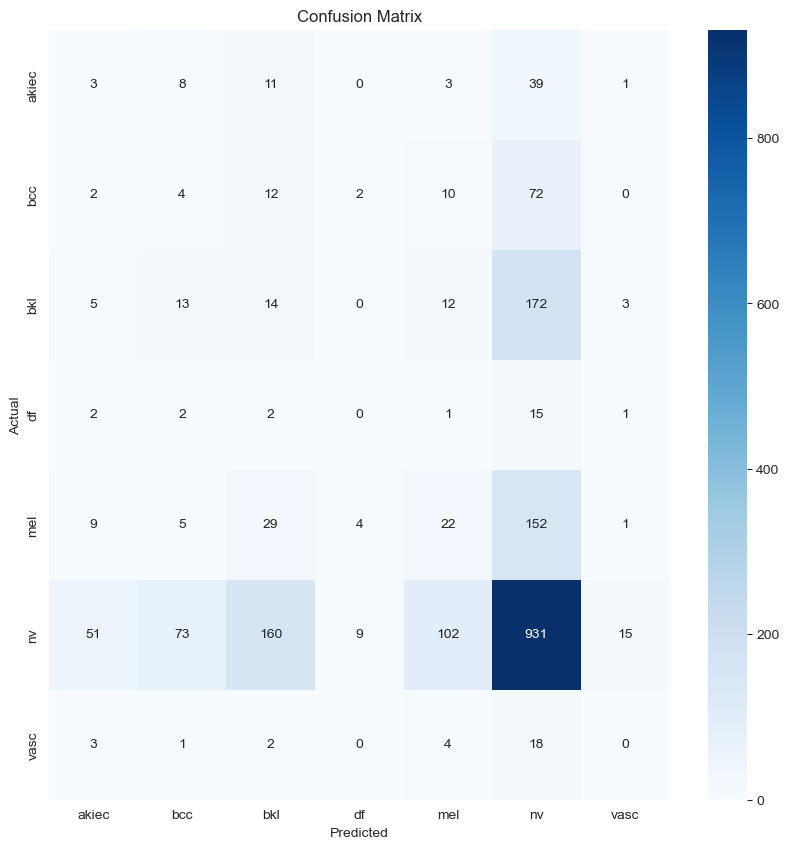

In [44]:
show_report(y_pred_initial_bias_only)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        65
         bcc       0.05      0.06      0.06       102
         bkl       0.12      0.11      0.11       219
          df       0.00      0.00      0.00        23
         mel       0.14      0.08      0.10       222
          nv       0.68      0.76      0.72      1341
        vasc       0.00      0.00      0.00        28

    accuracy                           0.53      2000
   macro avg       0.14      0.14      0.14      2000
weighted avg       0.49      0.53      0.51      2000



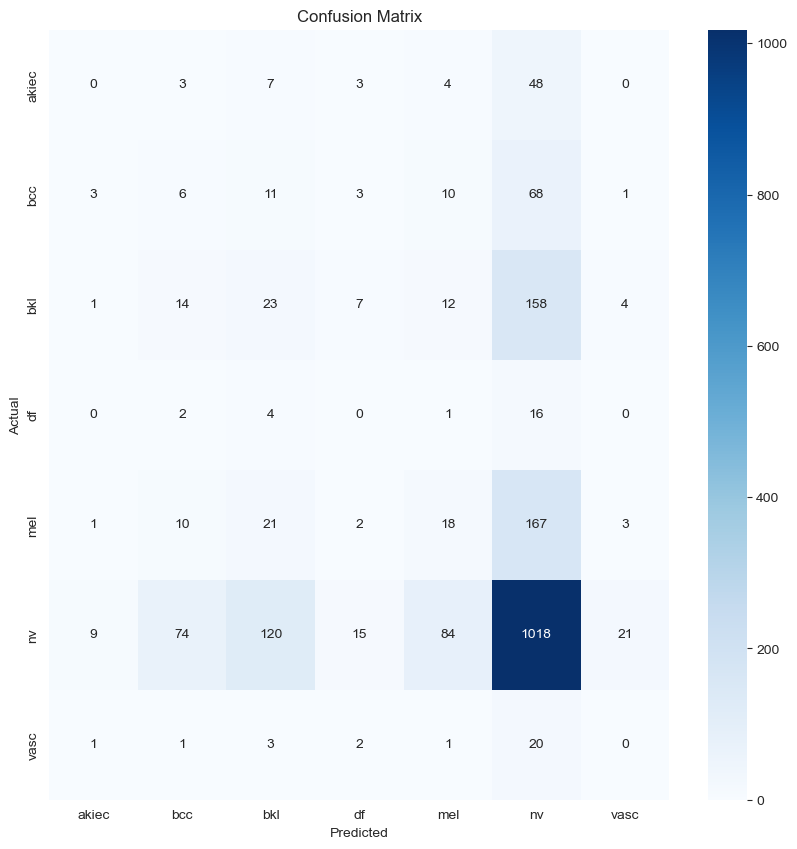

In [45]:
show_report(y_pred_oversampling_only)

              precision    recall  f1-score   support

       akiec       0.03      0.05      0.04        65
         bcc       0.02      0.01      0.01       102
         bkl       0.09      0.07      0.08       219
          df       0.00      0.00      0.00        23
         mel       0.09      0.09      0.09       222
          nv       0.68      0.71      0.69      1341
        vasc       0.04      0.04      0.04        28

    accuracy                           0.50      2000
   macro avg       0.14      0.14      0.14      2000
weighted avg       0.48      0.50      0.49      2000



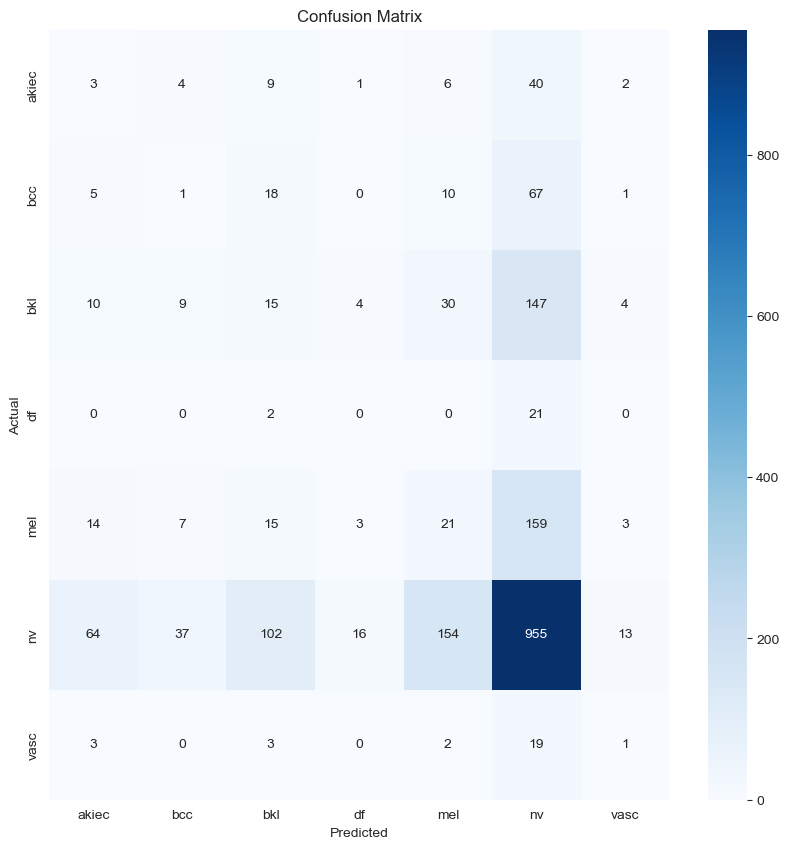

In [46]:
show_report(y_pred_oversampling_and_bias)